# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

##**Loading Libraries & Data**

In [211]:
import pandas as pd
pd.set_option("display.max_colwidth", 180) 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import math


import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings
warnings.filterwarnings('ignore')

In [212]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
#Importing Data
file_path = '/content/drive/MyDrive/Online Retail.xlsx'
df = pd.read_excel(file_path)

##**Exploring Data**

In [214]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [215]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [216]:
df.shape

(541909, 8)

Checking if there exists any NULL in the data.

In [217]:
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


Calculating Missing Values in Percentage%

In [218]:
print(round(100*(df.isnull().sum())/len(df), 2))

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64


In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [220]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## **Data Cleaning**

Handling Missing Values in CustomerID.

In [221]:
df['CustomerID_is_null'] = [1 if i == True else 0 for i in df.CustomerID.isnull()]

In [222]:
newdf = df[df['CustomerID_is_null'] == 1]

In [223]:
newdf.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom,1
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,1
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,1
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,1
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,1


In [224]:
#Creating New Customer ID
df['NewCustomerID'] = df['CustomerID']
df.loc[df['CustomerID_is_null'] == 1, ['NewID']] = df['InvoiceNo']

In [225]:
#Remove all non digits from column NewCustomerID
df['NewCustomerID'] = df['NewCustomerID'].astype(str).str.replace('\D+', '')

#Convert to integer
df['NewCustomerID'] = pd.to_numeric(df['NewCustomerID'])

#Check if the 'C' character was removed in the NewCustomerID column
df[df['NewCustomerID']== 580605]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,NewCustomerID,NewID


Removing Duplicate Entries

In [226]:
print('Duplicate entries: {}'.format(df.duplicated().sum()))

Duplicate entries: 5268


In [227]:
df.drop_duplicates(inplace = True)

Removing Cancelled Orders

In [228]:
co = df['InvoiceNo']

In [229]:
x = co.str.contains('C', regex=True)
x.fillna(0, inplace=True)

In [230]:
x = x.astype(int)

In [231]:
x.value_counts()

0    527390
1      9251
Name: InvoiceNo, dtype: int64

In [232]:
df['order_cancelled'] = x
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,NewCustomerID,NewID,order_cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,178500.0,NaN,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500.0,NaN,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,178500.0,NaN,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500.0,NaN,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500.0,NaN,0


In [233]:
df['order_cancelled'].value_counts()

0    527390
1      9251
Name: order_cancelled, dtype: int64

In [234]:
df = df.loc[df['order_cancelled'] == 0,:]

In [235]:
df.reset_index(drop=True,inplace=True)

Checking if we have negative quantities against any InvoiceNo.

In [236]:
df.loc[df['Quantity'] < 0,:]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,NewCustomerID,NewID,order_cancelled
2336,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,1,NaN,536589,0
4249,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom,1,NaN,536764,0
7003,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,1,NaN,536996,0
7004,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,1,NaN,536997,0
7005,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom,1,NaN,536998,0
...,...,...,...,...,...,...,...,...,...,...,...,...
520928,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom,1,NaN,581210,0
520930,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom,1,NaN,581212,0
520931,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom,1,NaN,581213,0
522503,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom,1,NaN,581226,0


We will remove these observations.

In [237]:
df = df[df['NewCustomerID'].notna()]

In [238]:
df.reset_index(drop=True,inplace=True)

In [239]:
df.shape

(392732, 12)

## **Exploratory Data Analysis**

Checking Unique Transactions, country , products and customers.

In [240]:
print("Unique Number of transactions: ", df['InvoiceNo'].nunique())
print("Unique Number of products bought: ", df['StockCode'].nunique())
print("Unique Number of customers:", df['NewCustomerID'].nunique())
print('Unique Number of countries: ', df['Country'].nunique())

Unique Number of transactions:  18536
Unique Number of products bought:  3665
Unique Number of customers: 4339
Unique Number of countries:  37


Checking country wise distribution of transactions.

In [241]:
temp = df.groupby(['Country'],as_index=False).agg({'InvoiceNo':'nunique'}).rename(columns = {'InvoiceNo':'Orders'})
total = temp['Orders'].sum(axis=0)
temp['%Orders'] = round((temp['Orders']/total)*100,4)

In [242]:
temp.sort_values(by=['%Orders'],ascending=False,inplace=True)
temp.reset_index(drop=True,inplace=True)

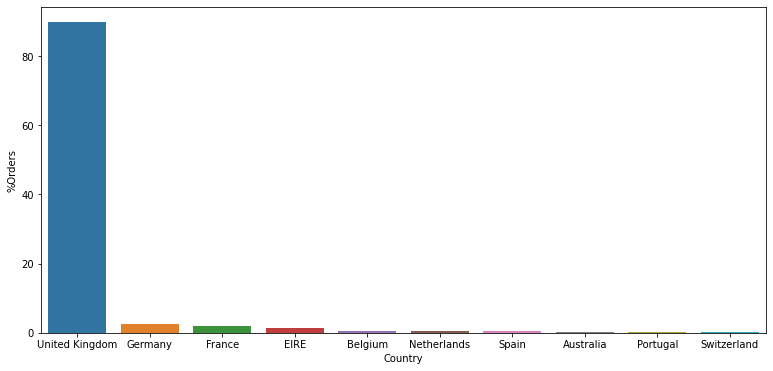

In [243]:
plt.figure(figsize=(13,6))
splot=sns.barplot(x="Country",y="%Orders",data=temp[:10])

We can clearly see that around 90% transactions are from United Kingdom so we will only consider United Kingdom for our further Analysis.

In [244]:
df_uk = df[df.Country == 'United Kingdom']

In [245]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,NewCustomerID,NewID,order_cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,178500.0,NaN,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500.0,NaN,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,178500.0,NaN,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500.0,NaN,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500.0,NaN,0


In [246]:
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349227 entries, 0 to 392716
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   InvoiceNo           349227 non-null  object        
 1   StockCode           349227 non-null  object        
 2   Description         349227 non-null  object        
 3   Quantity            349227 non-null  int64         
 4   InvoiceDate         349227 non-null  datetime64[ns]
 5   UnitPrice           349227 non-null  float64       
 6   CustomerID          349227 non-null  float64       
 7   Country             349227 non-null  object        
 8   CustomerID_is_null  349227 non-null  int64         
 9   NewCustomerID       349227 non-null  float64       
 10  NewID               0 non-null       object        
 11  order_cancelled     349227 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 34.6+ MB


Calculating average number of orders per customer.

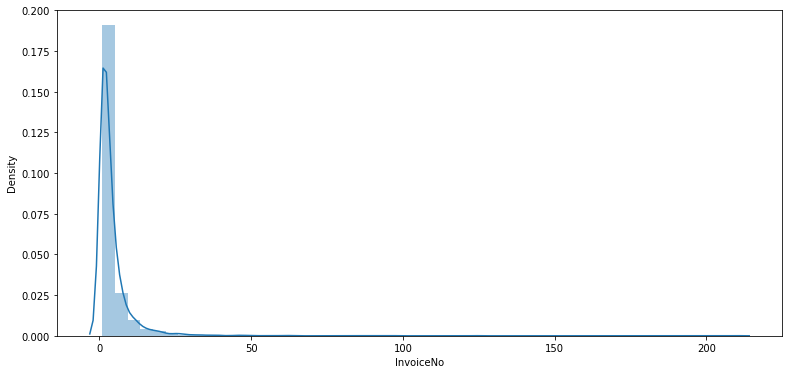

In [247]:
plt.figure(figsize=(13,6))
sns.distplot(df_uk.groupby('NewCustomerID')['InvoiceNo'].nunique())

In [248]:
groupby_customers = pd.DataFrame(df_uk.groupby('NewCustomerID')['InvoiceNo'].nunique())
groupby_customers.head()

,InvoiceNo
NewCustomerID,
123460.0,1
127470.0,11
127480.0,210
127490.0,5
128200.0,4


In [249]:
groupby_customers.describe()

,InvoiceNo
count,3921.000000
mean,4.246111
std,7.205750
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,210.000000


The average number of orders per customer is 4.

Calculating average number of unqiue items per order.

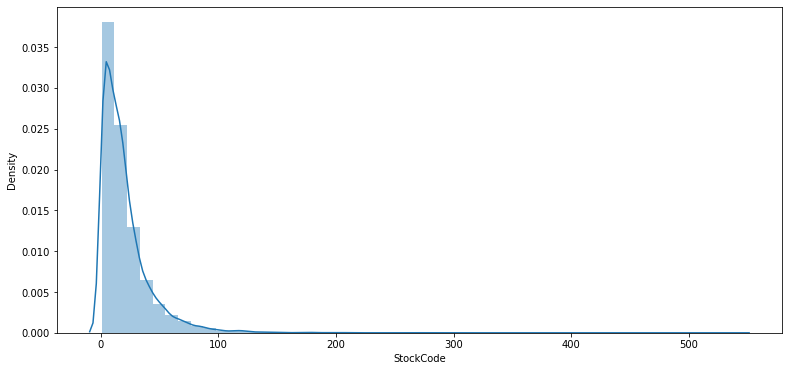

In [250]:
plt.figure(figsize=(13,6))
sns.distplot(df_uk.groupby('InvoiceNo')['StockCode'].nunique())

In [251]:
groupby_invoice = pd.DataFrame(df_uk.groupby('InvoiceNo')['StockCode'].nunique())
groupby_invoice.columns = ['Number of Items per Order']
groupby_invoice.head()

,Number of Items per Order
InvoiceNo,
536365,7
536366,2
536367,12
536368,4
536369,1


In [252]:
groupby_invoice.describe()

,Number of Items per Order
count,16649.000000
mean,20.689231
std,23.946230
min,1.000000
25%,6.000000
50%,15.000000
75%,27.000000
max,541.000000


The average number of unqiue items per order is 20.

Calculating average number of unqiue products per Customer.

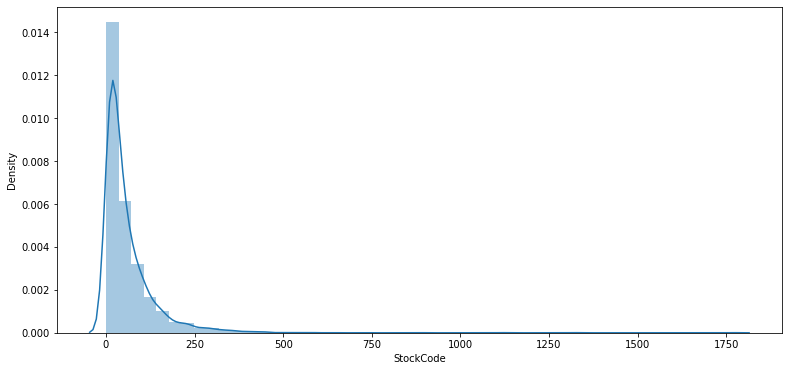

In [253]:
plt.figure(figsize=(13,6))
sns.distplot(df_uk.groupby('NewCustomerID')['StockCode'].nunique())

In [254]:
groupby_customer_ID = pd.DataFrame(df_uk.groupby('NewCustomerID')['StockCode'].nunique())
groupby_customer_ID.columns = ['Number of Items per Customer']
groupby_customer_ID.head()

,Number of Items per Customer
NewCustomerID,
123460.0,1
127470.0,42
127480.0,1768
127490.0,160
128200.0,55


In [255]:
groupby_customer_ID.describe()

,Number of Items per Customer
count,3921.000000
mean,60.712318
std,81.666297
min,1.000000
25%,15.000000
50%,35.000000
75%,77.000000
max,1768.000000


The average number of unqiue products per Customer 60.

Top 10 Products bought in Uk.

In [256]:
top10 = df_uk.groupby(['StockCode','Description'],as_index= False)['Quantity'].sum().sort_values(by='Quantity', ascending=False).head(10)
top10

,StockCode,Description,Quantity
2514,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
2016,23166,MEDIUM CERAMIC TOP STORAGE JAR,76919
2690,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49086
3548,85099B,JUMBO BAG RED RETROSPOT,41878
3555,85123A,WHITE HANGING HEART T-LIGHT HOLDER,34630
2795,84879,ASSORTED COLOUR BIRD ORNAMENT,32628
1031,22197,POPCORN HOLDER,28923
1426,22616,PACK OF 12 LONDON TISSUES,24321
37,17003,BROCADE RING PURSE,22675
356,21212,PACK OF 72 RETROSPOT CAKE CASES,22442


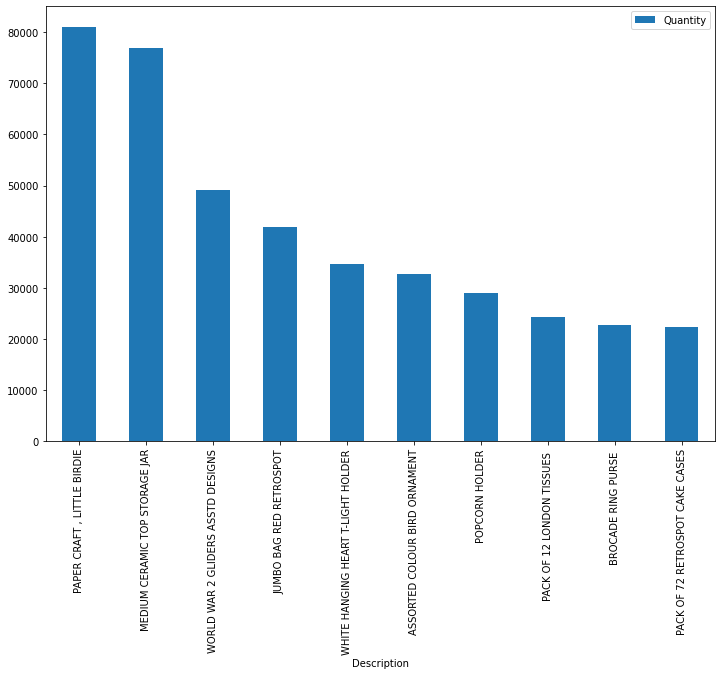

In [257]:
#Bar Graph
top10.plot.bar(x='Description', y='Quantity',figsize=(12,8))

## **RFM Analysis & Data Preprocessing**

1.   R (Recency): Number of days since last purchase.
2.   F (Frequency): Number of tracsactions.
3.   M (Monetary): Total amount of transactions (revenue contributed)


We will add the Total Cost column.

In [258]:
df_uk['Total_Cost'] = df_uk['Quantity'] * df_uk['UnitPrice']
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,NewCustomerID,NewID,order_cancelled,Total_Cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,178500.0,NaN,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500.0,NaN,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,178500.0,NaN,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500.0,NaN,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500.0,NaN,0,20.34


In [259]:
#  Monetary column
rfm_m = df_uk.groupby('NewCustomerID')['Total_Cost'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,NewCustomerID,Total_Cost
0,123460.0,77183.60
1,127470.0,4196.01
2,127480.0,33053.19
3,127490.0,4090.88
4,128200.0,942.34


In [260]:
#  Frequency column
rfm_f = df_uk.groupby('NewCustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['NewCustomerID', 'Frequency']
rfm_f.head()

,NewCustomerID,Frequency
0,123460.0,1
1,127470.0,103
2,127480.0,4413
3,127490.0,199
4,128200.0,59


In [261]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='NewCustomerID', how='inner')
rfm.head()

,NewCustomerID,Total_Cost,Frequency
0,123460.0,77183.60,1
1,127470.0,4196.01,103
2,127480.0,33053.19,4413
3,127490.0,4090.88,199
4,128200.0,942.34,59


In [262]:
# Recency

#Convert to datetime to proper datatype
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [263]:
# we will calculate maximum date to know the last transaction date

max_date = max(df_uk['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:49:00')

In [264]:
df_uk['Diff'] = max_date - df_uk['InvoiceDate']
df_uk.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,NewCustomerID,NewID,order_cancelled,Total_Cost,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,178500.0,NaN,0,15.30,373 days 04:23:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500.0,NaN,0,20.34,373 days 04:23:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,178500.0,NaN,0,22.00,373 days 04:23:00


In [265]:
# we will calculate last transaction date to get the recency of customers

rfm_p = df_uk.groupby('NewCustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,NewCustomerID,Diff
0,123460.0,325 days 02:48:00
1,127470.0,1 days 22:15:00
2,127480.0,0 days 00:29:00
3,127490.0,3 days 02:53:00
4,128200.0,2 days 21:37:00


In [266]:
# we will extract number of days.

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,NewCustomerID,Diff
0,123460.0,325
1,127470.0,1
2,127480.0,0
3,127490.0,3
4,128200.0,2


In [267]:
# Final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='NewCustomerID', how='inner')
rfm.columns = ['NewCustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,NewCustomerID,Amount,Frequency,Recency
0,123460.0,77183.60,1,325
1,127470.0,4196.01,103,1
2,127480.0,33053.19,4413,0
3,127490.0,4090.88,199,3
4,128200.0,942.34,59,2


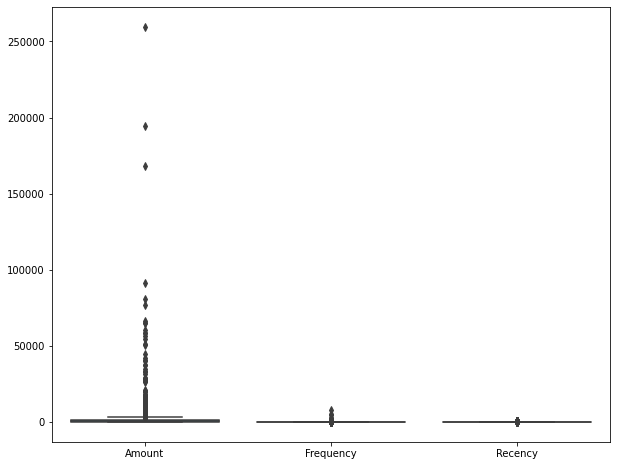

In [278]:
# Looking For Outliers
a = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[a])

In [279]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

## **Rescaling Features**

In [280]:
# Rescaling the attributes
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Standard Scaler
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3849, 3)

In [285]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,1.750869,0.280075,-0.918922
1,1.688565,1.254390,-0.898856
2,-0.177362,-0.166486,-0.908889
3,-0.680874,-0.704389,1.208054
4,-0.173486,-0.298425,-0.226651


# **Modeling**

## K-Means Clustering


In [286]:
#Randomly we will take K value.
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [287]:
kmeans.labels_

array([3, 3, 0, ..., 0, 2, 0], dtype=int32)

We will find Optimal number of K.

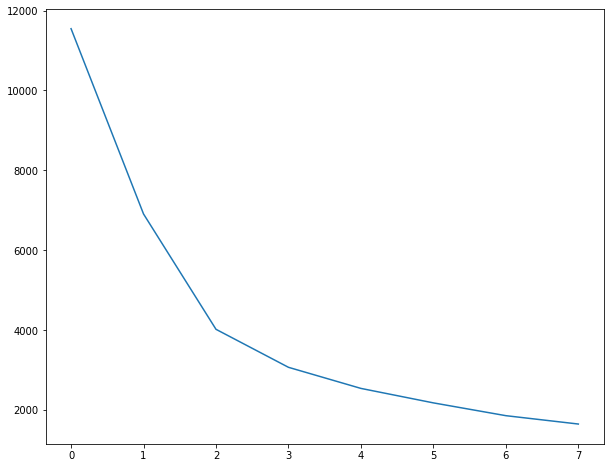

In [288]:
# Elbow-curve

elbow_c = []
range_n_clusters = [1,2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    elbow_c.append(kmeans.inertia_)
    
# we will plot the Elbow-curve
plt.plot(elbow_c)

We will try another method.

In [289]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
  
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5410942294194272
For n_clusters=3, the silhouette score is 0.5074991019579109
For n_clusters=4, the silhouette score is 0.4780968160774425
For n_clusters=5, the silhouette score is 0.46679023091595084
For n_clusters=6, the silhouette score is 0.4187221330762404
For n_clusters=7, the silhouette score is 0.41633041883360744
For n_clusters=8, the silhouette score is 0.4102519631578953


In [291]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [292]:
 kmeans.labels_

array([0, 0, 1, ..., 1, 0, 1], dtype=int32)

In [293]:
# assigning the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,NewCustomerID,Amount,Frequency,Recency,Cluster_Id
1,127470.0,4196.01,103,1,0
3,127490.0,4090.88,199,3,0
4,128200.0,942.34,59,2,1
5,128210.0,92.72,6,213,2
6,128220.0,948.88,46,70,1


We will visualize Cluster ID vs RFM

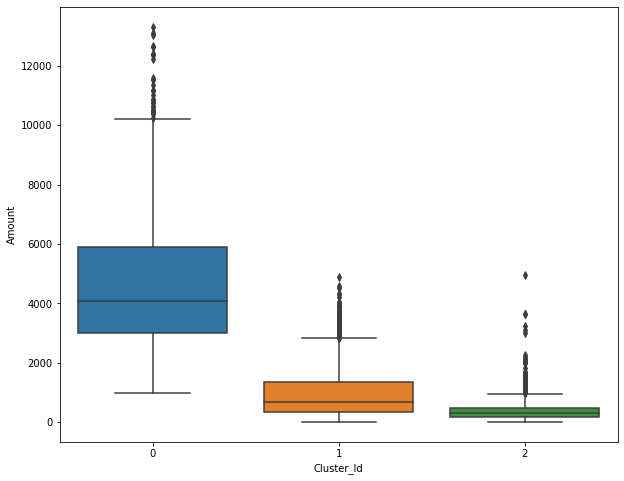

In [294]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

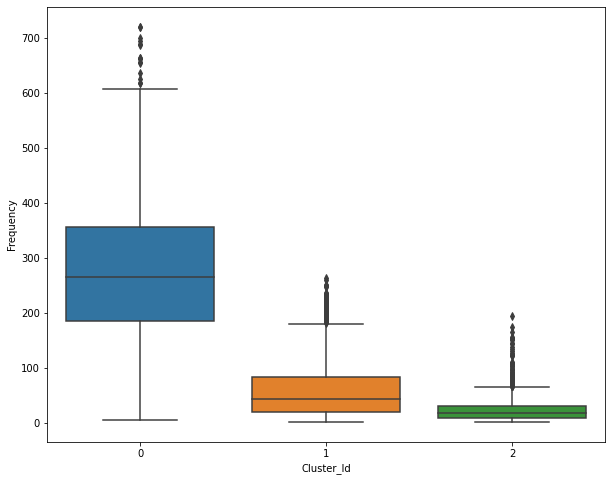

In [295]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

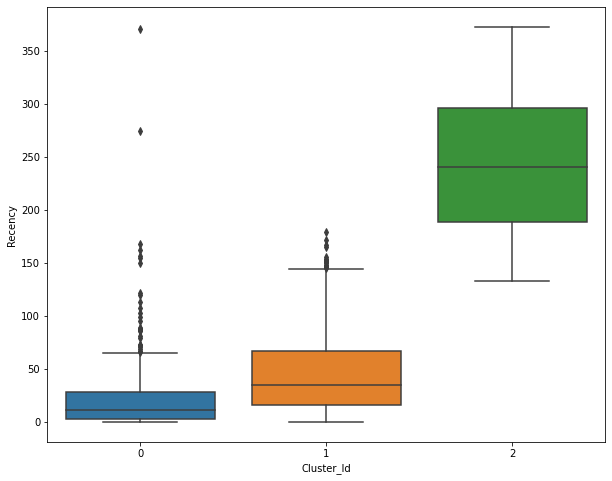

In [296]:
# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

# **Conclusion**



1.   Customers with Cluster Id 0 are the customers with high amount of transactions as compared to other customers.
2.   Customers with Cluster Id 0 are frequent buyers.
3.   Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.


